Quante evidenze archeologiche di epoca romana sono presenti in Italia?

Curiosando sul [Catalogo generale dei Beni Culturali](https://catalogo.beniculturali.it/) mi aspettavo di trovare una risposta ma non è stato così. Già solo accedendo al portale, senza applicare nessun tipo di filtro, effettuando uno zoom sull'area dei Campi Flegrei mi ritrovo nella situazione che segue.

<p align="center">
  <img width="100%" height="800px" src="zoom_campi_flegrei.png">
</p>

E' presente il solo [Castello di Baia](https://www.campiflegreionline.it/Castello_di_Baia.html) in questa area, secondo il catalogo, ma nella realtà in quest'area possiamo trovare:
- la [Piscina Mirabilis](https://piscinamirabilisbacoli.it/it)
- la [Casina Vanvitelliana](https://www.prolococittadibacoli.it/casina-vanvitelliana/)
- [Baia sommersa](https://www.baiasommersa.it/)
- il [Tempio di Serapide](http://www.pafleg.it/it/4388/localita/67/macellum-tempio-di-serapide)
- il [Parco archeologico del Pausilypon](https://www.areamarinaprotettagaiola.it/pausilypon)

Solo per citare i luoghi che conosco per averli visitati direttamente, ma ce ne sono tanti altri.

Così ho deciso di usare i superpoteri di Python e [OpenStreetMap](https://www.openstreetmap.org/) per darmi una risposta.

## Prima di iniziare


### Librerie
Per raggiungere l'obiettivo userò le librerie che seguono.

In [20]:
from pathlib import Path
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import contextily as cx
import osmnx as ox

### Fonti dati
Oltre ai dati di OpenStreetMap userò i confini comunali generalizzati 2023 rilasciati da ISTAT.


In [35]:
main_folder = Path.cwd().parent.parent.parent.parent.joinpath('sample_data')
municipalities = main_folder.joinpath('Com01012023_g').joinpath('Com01012023_g_WGS84.shp')
regions = main_folder.joinpath('Reg01012023_g').joinpath('Reg01012023_g_WGS84.shp')

osm_crs = 4326

municipalities_gdf = gpd.read_file(municipalities).to_crs(osm_crs)
regions_gdf = gpd.read_file(regions).to_crs(osm_crs)

regions_gdf

,COD_RIP,COD_REG,DEN_REG,Shape_Leng,Shape_Area,geometry
0,1,1,Piemonte,1.236800e+06,2.539388e+10,"POLYGON ((8.44976 46.46176, 8.46176 46.45081, ..."
1,1,2,Valle d'Aosta,3.109681e+05,3.258838e+09,"POLYGON ((7.58857 45.97075, 7.58981 45.97073, ..."
2,1,3,Lombardia,1.410223e+06,2.386232e+10,"MULTIPOLYGON (((8.81642 45.02231, 8.81427 45.0..."
3,2,4,Trentino-Alto Adige,8.008937e+05,1.360755e+10,"POLYGON ((12.20511 47.08653, 12.20668 47.08627..."
4,2,5,Veneto,1.054587e+06,1.834355e+10,"POLYGON ((12.50591 46.67839, 12.50603 46.67803..."
5,2,6,Friuli Venezia Giulia,6.708207e+05,7.934116e+09,"MULTIPOLYGON (((13.77538 45.61068, 13.77538 45..."
6,1,7,Liguria,8.196598e+05,5.414542e+09,"MULTIPOLYGON (((9.85132 44.02340, 9.85122 44.0..."
7,2,8,Emilia-Romagna,1.180343e+06,2.249987e+10,"MULTIPOLYGON (((10.48080 44.18949, 10.48069 44..."
8,3,9,Toscana,1.306243e+06,2.298404e+10,"MULTIPOLYGON (((11.11471 42.25911, 11.11625 42..."
9,3,10,Umbria,6.197684e+05,8.464380e+09,"MULTIPOLYGON (((12.43119 43.59136, 12.43030 43..."


Come vedremo in seguito tornerà molto utile conoscere la tassonomia di OpenStreetMap, tassonomia disponibile [qui](https://wiki.openstreetmap.org/wiki/Map_features).

## Rimozione dei warnings
Il codice che segue serve solo per eliminare i messaggi di warning che renderebbero antiestetico l'articolo. **Attenzione ad ignorarli però!** Vanno ben approfonditi e non ignorati alla leggera. Io lo faccio solo perchè questo è un articolo dimostrativo.

In [22]:
# import warnings
# warnings.filterwarnings('ignore')
# warnings.simplefilter('ignore')

## Contenuti
- [1. Lavoriamo in piccolo: Bacoli](#1.-Lavoriamo-in-piccolo:-Bacoli)
- [2. Ricerca a scala regionale: Campania](#2.-Ricerca-a-scala-regionale:-Campania)
- [Conclusione](#Conclusione)

# 1. Lavoriamo in piccolo: Bacoli
Partiremo con l'analizzare l'area di Bacoli. 

In [23]:
bacoli = municipalities_gdf[municipalities_gdf['COMUNE']=='Bacoli'].squeeze()
bacoli

COD_RIP                                                       4
COD_REG                                                      15
COD_PROV                                                     63
COD_CM                                                      263
COD_UTS                                                     263
PRO_COM                                                   63006
PRO_COM_T                                                063006
COMUNE                                                   Bacoli
COMUNE_A                                                    NaN
CC_UTS                                                        0
Shape_Leng                                         20303.054123
geometry      POLYGON ((14.06724657892957 40.842943679557926...
Name: 5138, dtype: object

Interrogheremo il database di OpenStreetMap usando [OSMnx](https://osmnx.readthedocs.io/en/stable/index.html) libreria che (cito dal sito del progetto) *is a Python package to download, model, analyze, and visualize street networks and other geospatial features from OpenStreetMap*. Andremo in particolare ad usare il TAG **historic** con alcune eccezioni che vedremo.

In [24]:
bacoli_data = ox.features_from_polygon(
    polygon=bacoli.geometry,
    tags={'historic': True}
)

bacoli_data

historic  \
element_type osmid                             
node         1045290525  archaeological_site   
             1104926219  archaeological_site   
             1139094827  archaeological_site   
             1139094838  archaeological_site   
             1706624371  archaeological_site   
             2235447677                ruins   
             2235447711             memorial   
             2235447893             memorial   
             8755033944                ruins   
             9060732167                ruins   
way          124092891   archaeological_site   
             124093354   archaeological_site   
             144917231                castle   
             240100401   archaeological_site   
             323122081              building   
             406222066   archaeological_site   
             429218964   archaeological_site   
             429324871   archaeological_site   
             429338160   archaeological_site   
             429339087   archaeological_site   
             429340403   archaeological_site   
             429341185   archaeological_site   
             429341186   archaeological_site   
             429341188   archaeological_site   
             429341189   archaeological_site   
             429341190   archaeological_site   
             736686146              building   
             736686737   archaeological_site   
             736690821   archaeological_site   
             1154634667  archaeological_site   

                                                     name   wikidata  \
element_type osmid                                                     
node         1045290525                 Piscina Mirabilis    Q222410   
             1104926219   Grotte dell'Acqua - Lago Fusaro        NaN   
             1139094827            Grotta della Dragonara  Q55673920   
             1139094838           Sacello degli Augustali   Q3944423   
             1706624371                 Grotta di Cocceio    Q518104   
             2235447677                               NaN        NaN   
             2235447711                            Bunker        NaN   
             2235447893                            Bunker        NaN   
             8755033944                    Tempo di Iside        NaN   
             9060732167                               NaN        NaN   
way          124092891   Parco Archeologico Terme di Baia   Q3685188   
             124093354                 Anfiteatro di Cuma  Q93976746   
             144917231         Castello Aragonese di Baia   Q3662303   
             240100401                 Tomba di Agrippina        NaN   
             323122081               Casina Vanvitelliana    Q958152   
             406222066                    Tempio di Diana        NaN   
             429218964                          Columbari        NaN   
             429324871            Monumental Park of Baia        NaN   
             429338160                 Tempio di Mercurio        NaN   
             429339087                   Tempio di Venere  Q96694237   
             429340403                                NaN        NaN   
             429341185                                NaN        NaN   
             429341186                                NaN        NaN   
             429341188                                NaN        NaN   
             429341189                                NaN        NaN   
             429341190                                NaN        NaN   
             736686146                                NaN        NaN   
             736686737                                NaN        NaN   
             736690821                                NaN        NaN   
             1154634667          Teatro romano di Misenum  Q55685837   

                                                 wikipedia  \
element_type osmid                                           
node         1045290525               en:Piscina Mirabilis   
        

Come si può vedere in quest'area ci sono ben 35 siti di interesse archeologico, molti più dei tre che conosco che fanno parte dell'elenco di inizio articolo.

Ma veniamo ai TAG di nostro interesse. Analizzando l'elenco delle [chiavi](https://wiki.openstreetmap.org/wiki/Map_features#Historic) ce ne sono alcune che non mi interessano e le inserirò nella viriabile che segue perchè a me interessano solo le strutture o i resti di strutture.

In [25]:
excluded_keys = ['aircraft', 'anchor', 'battlefield', 'bomb_crater', 'boundary_stone', 'cannon', 'cattle_crush', 'district', 'highwater_mark', 'locomotive', 'ogham_stone', 'railway_car', 'road', 'shieling', 'ship', 'tank', 'vehicle', 'wayside_cross', 'wayside_shrine', 'wreck']

excluded_keys

['aircraft',
 'anchor',
 'battlefield',
 'bomb_crater',
 'boundary_stone',
 'cannon',
 'cattle_crush',
 'district',
 'highwater_mark',
 'locomotive',
 'ogham_stone',
 'railway_car',
 'road',
 'shieling',
 'ship',
 'tank',
 'vehicle',
 'wayside_cross',
 'wayside_shrine',
 'wreck']

Inoltre escluderò anche alcune colonne dal dataset primario in modo da restringere ulteriormente il campo.

In [26]:
bacoli_data = bacoli_data[['historic', 'name', 'historic:civilization', 'geometry']]
bacoli_data = bacoli_data[~bacoli_data['historic'].isin(excluded_keys)]
bacoli_data = bacoli_data[bacoli_data['name'].notna()]
bacoli_data.reset_index(inplace=True)

bacoli_data

,element_type,osmid,historic,name,historic:civilization,geometry
0,node,1045290525,archaeological_site,Piscina Mirabilis,NaN,POINT (14.08028 40.79519)
1,node,1104926219,archaeological_site,Grotte dell'Acqua - Lago Fusaro,NaN,POINT (14.05955 40.82506)
2,node,1139094827,archaeological_site,Grotta della Dragonara,NaN,POINT (14.08506 40.78477)
3,node,1139094838,archaeological_site,Sacello degli Augustali,NaN,POINT (14.08460 40.78747)
4,node,1706624371,archaeological_site,Grotta di Cocceio,ancient_roman_-_Augustus_Emperator_period,POINT (14.06211 40.84534)
5,node,2235447711,memorial,Bunker,NaN,POINT (14.06457 40.82321)
6,node,2235447893,memorial,Bunker,NaN,POINT (14.06555 40.82358)
7,node,8755033944,ruins,Tempo di Iside,NaN,POINT (14.05002 40.84415)
8,way,124092891,archaeological_site,Parco Archeologico Terme di Baia,ancient_roman,"POLYGON ((14.07084 40.81923, 14.07072 40.81929..."
9,way,124093354,archaeological_site,Anfiteatro di Cuma,ancient_roman,"POLYGON ((14.05636 40.84248, 14.05598 40.84255..."


Purtroppo a causa del fatto che la colonna *historic:civilization* non è corrattamente campita non riuscirò a sfruttare correttamente i dati a disposizione per rispondere alla mia domanda iniziale, ma meglio di niente. Alcuni siti come la **Piscina Mirabilis** sono di epoca romana ma questo non viene indicato nella colonna in questione per cui se pure volessi filtrare i dati cercando `roman` con la funzione `str.contains` di [Pandas](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.contains.html?highlight=contains#pandas.Series.str.contains) otterei meno dati del previsto. E' un peccato perchè sotto ` Rome` [OpenStreetMap](https://wiki.openstreetmap.org/wiki/Key:historic:civilization#Rome) ha un bel po' di possibilità di ricerca potendo filtrare i dati in base ai vari periodi in cui si è sviluppata la civiltà romana antica.

Come avrete sicuramente notato, il dataset ha geometrie miste. Di seguito lo normalizzerò per fare in modo da avere solo punti.

In [27]:
bacoli_polygons = bacoli_data[bacoli_data['element_type']=='way']

bacoli_polygons

,element_type,osmid,historic,name,historic:civilization,geometry
8,way,124092891,archaeological_site,Parco Archeologico Terme di Baia,ancient_roman,"POLYGON ((14.07084 40.81923, 14.07072 40.81929..."
9,way,124093354,archaeological_site,Anfiteatro di Cuma,ancient_roman,"POLYGON ((14.05636 40.84248, 14.05598 40.84255..."
10,way,144917231,castle,Castello Aragonese di Baia,NaN,"POLYGON ((14.08025 40.81003, 14.08046 40.81018..."
11,way,240100401,archaeological_site,Tomba di Agrippina,NaN,"POLYGON ((14.08145 40.80291, 14.08133 40.80294..."
12,way,323122081,building,Casina Vanvitelliana,NaN,"POLYGON ((14.05844 40.81979, 14.05847 40.81983..."
13,way,406222066,archaeological_site,Tempio di Diana,NaN,"POLYGON ((14.07065 40.81926, 14.07043 40.81923..."
14,way,429218964,archaeological_site,Columbari,NaN,"POLYGON ((14.06482 40.81952, 14.06543 40.81914..."
15,way,429324871,archaeological_site,Monumental Park of Baia,NaN,"POLYGON ((14.07125 40.81337, 14.07098 40.81320..."
16,way,429338160,archaeological_site,Tempio di Mercurio,NaN,"POLYGON ((14.06978 40.81790, 14.06982 40.81792..."
17,way,429339087,archaeological_site,Tempio di Venere,NaN,"POLYGON ((14.07139 40.81624, 14.07152 40.81627..."


In [28]:
bacoli_polygons['centroid'] = bacoli_polygons.geometry.centroid
bacoli_polygons.drop(columns={'geometry'}, inplace=True)
bacoli_polygons.rename(columns={'centroid': 'geometry'}, inplace=True)

bacoli_polygons

/tmp/ipykernel_17880/311082464.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bacoli_polygons['centroid'] = bacoli_polygons.geometry.centroid
/home/max/.cache/pypoetry/virtualenvs/pygis_blog-iPs2SW5R-py3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_17880/311082464.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

,element_type,osmid,historic,name,historic:civilization,geometry
8,way,124092891,archaeological_site,Parco Archeologico Terme di Baia,ancient_roman,POINT (14.07024 40.81724)
9,way,124093354,archaeological_site,Anfiteatro di Cuma,ancient_roman,POINT (14.05604 40.84199)
10,way,144917231,castle,Castello Aragonese di Baia,NaN,POINT (14.08032 40.81106)
11,way,240100401,archaeological_site,Tomba di Agrippina,NaN,POINT (14.08128 40.80285)
12,way,323122081,building,Casina Vanvitelliana,NaN,POINT (14.05842 40.81971)
13,way,406222066,archaeological_site,Tempio di Diana,NaN,POINT (14.07056 40.81914)
14,way,429218964,archaeological_site,Columbari,NaN,POINT (14.06500 40.81928)
15,way,429324871,archaeological_site,Monumental Park of Baia,NaN,POINT (14.07141 40.81283)
16,way,429338160,archaeological_site,Tempio di Mercurio,NaN,POINT (14.06987 40.81782)
17,way,429339087,archaeological_site,Tempio di Venere,NaN,POINT (14.07152 40.81612)


In [29]:
bacoli_final = pd.concat([bacoli_polygons, bacoli_data[bacoli_data['element_type']=='node']])
bacoli_final.drop(columns={'element_type'}, inplace=True)
bacoli_final.sort_values(by='name', inplace=True)
bacoli_final = gpd.GeoDataFrame(bacoli_final, geometry='geometry')

bacoli_final

,osmid,historic,name,historic:civilization,geometry
9,124093354,archaeological_site,Anfiteatro di Cuma,ancient_roman,POINT (14.05604 40.84199)
5,2235447711,memorial,Bunker,NaN,POINT (14.06457 40.82321)
6,2235447893,memorial,Bunker,NaN,POINT (14.06555 40.82358)
12,323122081,building,Casina Vanvitelliana,NaN,POINT (14.05842 40.81971)
10,144917231,castle,Castello Aragonese di Baia,NaN,POINT (14.08032 40.81106)
14,429218964,archaeological_site,Columbari,NaN,POINT (14.06500 40.81928)
2,1139094827,archaeological_site,Grotta della Dragonara,NaN,POINT (14.08506 40.78477)
4,1706624371,archaeological_site,Grotta di Cocceio,ancient_roman_-_Augustus_Emperator_period,POINT (14.06211 40.84534)
1,1104926219,archaeological_site,Grotte dell'Acqua - Lago Fusaro,NaN,POINT (14.05955 40.82506)
15,429324871,archaeological_site,Monumental Park of Baia,NaN,POINT (14.07141 40.81283)


Ora che il dataset è di soli punti cerchiamo di rispondere a qualche domanda.

## 1.1. Come sono raggruppati i siti?

In [30]:
bacoli_group = bacoli_final.groupby(by='historic').count()
bacoli_group.drop(columns={'name', 'historic:civilization', 'geometry'}, inplace=True)
bacoli_group.rename(columns={'osmid': 'count'}, inplace=True)
bacoli_group.sort_values(by='count', ascending=False, inplace=True)

bacoli_group

,count
historic,
archaeological_site,14
memorial,2
building,1
castle,1
ruins,1


## 1.2. Dove sono localizzati?

<Axes: title={'center': 'Comune di Bacoli'}>

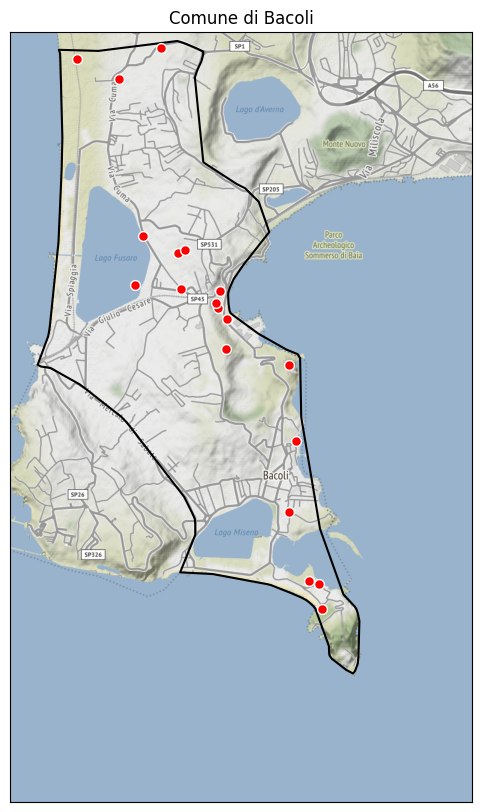

In [31]:
contextily_tile_crs = 3857

bacoli_polygon = gpd.GeoDataFrame(geometry=gpd.GeoSeries(bacoli.geometry), crs=osm_crs).to_crs(contextily_tile_crs)


b_minx, b_miny, b_maxx, b_maxy = bacoli_polygon.squeeze().bounds

bacoli_img, bacoli_ext = cx.bounds2img(w=b_minx, s=b_miny, e=b_maxx, n=b_maxy, ll=False)

fig, ax = plt.subplots(figsize=(10, 10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title('Comune di Bacoli')

ax.imshow(bacoli_img, extent=bacoli_ext, zorder=0)
bacoli_polygon.boundary.plot(ax=ax, edgecolor='black', zorder=1)
bacoli_final.to_crs(contextily_tile_crs).plot(ax=ax, marker="o", facecolor='red', edgecolor='white', markersize=50, zorder=2)


# 2. Ricerca a scala regionale: Campania

In [37]:
campania = regions_gdf[regions_gdf['DEN_REG']=='Campania'].squeeze()

campania

COD_RIP                                                       4
COD_REG                                                      15
DEN_REG                                                Campania
Shape_Leng                                         888166.70685
Shape_Area                                   13663252600.799999
geometry      MULTIPOLYGON (((15.294678222474477 40.02369364...
Name: 14, dtype: object

In [38]:
campania_data = ox.features_from_polygon(
    polygon=campania.geometry,
    tags={'historic': True}
)

campania_data

historic  \
element_type osmid                  
node         1233738646     ruins   
             1234013962    castle   
             1278425106     ruins   
             1456773590     ruins   
             1601204543  monument   
...                           ...   
way          1105039541     ruins   
             1109860259    castle   
             1119447938  building   
             1120991526  building   
relation     10557325      castle   

                                                                  geometry  \
element_type osmid                                                           
node         1233738646                          POINT (15.51893 40.07559)   
             1234013962                          POINT (15.55494 40.13962)   
             1278425106                          POINT (15.42702 40.27348)   
             1456773590                          POINT (15.36115 39.99905)   
             1601204543                          POINT (15.32197 40.15126)   
...                                                                    ...   
way          1105039541  POLYGON ((13.88314 41.12800, 13.88307 41.12790...   
             1109860259  POLYGON ((14.25132 41.36490, 14.25159 41.36487...   
             1119447938  POLYGON ((14.15338 41.26210, 14.15339 41.26206...   
             1120991526  POLYGON ((14.22349 41.27448, 14.22348 41.27437...   
relation     10557325    POLYGON ((13.93373 41.23848, 13.93372 41.23847...   

                                                             name religion  \
element_type osmid                                                           
node         1233738646                                       NaN      NaN   
             1234013962                                       NaN      NaN   
             1278425106                                       NaN      NaN   
             1456773590                          Torre dell'Isola      NaN   
             1601204543           Chiesa di San Marco Evangelista      NaN   
...                                                           ...      ...   
way          1105039541                                       NaN      NaN   
             1109860259                                Rupecanina      NaN   
             1119447938                       Torre dell'orologio      NaN   
             1120991526  Scuola Municipale Storica di Roccaromana      NaN   
relation     10557325                             Castello ducale      NaN   

                        access name:bg name:it alt_name archaeological_site  \
element_type osmid                                                            
node         1233738646    NaN     NaN     NaN      NaN                 NaN   
             1234013962    NaN     NaN     NaN      NaN                 NaN   
             1278425106    NaN     NaN     NaN      NaN                 NaN   
             1456773590    NaN     NaN     NaN      NaN                 NaN   
             1601204543    NaN     NaN     NaN      NaN                 NaN   
...                        ...     ...     ...      ...                 ...   
way          1105039541    NaN     NaN     NaN      NaN                 NaN   
             1109860259    NaN     NaN     NaN      NaN                 NaN   
             1119447938    NaN     NaN     NaN      NaN                 NaN   
             1120991526    NaN     NaN     NaN      NaN                 NaN   
relation     10557325      NaN     NaN     NaN      NaN                 NaN   

                           addr:city  ... old_name operator:type disused pump  \
element_type osmid                    ...                                       
node         1233738646          NaN  ...      NaN           NaN     NaN  NaN   
             1234013962          NaN  ...      NaN           NaN     NaN  NaN   
             1278425106          NaN  ...      NaN           NaN     NaN  NaN   
             1456773590          NaN  ...      NaN           NaN     NaN  NaN   

In [39]:
campania_data = campania_data[['historic', 'name', 'historic:civilization', 'geometry']]
campania_data = campania_data[~campania_data['historic'].isin(excluded_keys)]
campania_data = campania_data[campania_data['name'].notna()]
campania_data.reset_index(inplace=True)

campania_data

,element_type,osmid,historic,name,historic:civilization,geometry
0,node,1456773590,ruins,Torre dell'Isola,NaN,POINT (15.36115 39.99905)
1,node,1601204543,monument,Chiesa di San Marco Evangelista,NaN,POINT (15.32197 40.15126)
2,node,1704137785,monument,Casa del Canonico Antonio Maria De Luca,NaN,POINT (15.40496 40.09458)
3,node,1711457809,ruins,Cappella S. Michele,NaN,POINT (15.37871 40.09500)
4,node,1711474362,memorial,Monumento ai caduti in guerra,NaN,POINT (15.40407 40.09596)
...,...,...,...,...,...,...
2076,way,1090715537,ruins,Rovine del Castello di Caianello,NaN,"POLYGON ((14.08538 41.29496, 14.08553 41.29500..."
2077,way,1109860259,castle,Rupecanina,NaN,"POLYGON ((14.25132 41.36490, 14.25159 41.36487..."
2078,way,1119447938,building,Torre dell'orologio,NaN,"POLYGON ((14.15338 41.26210, 14.15339 41.26206..."
2079,way,1120991526,building,Scuola Municipale Storica di Roccaromana,NaN,"POLYGON ((14.22349 41.27448, 14.22348 41.27437..."


In [40]:
campania_polygons = campania_data[campania_data['element_type']=='way']

campania_polygons

,element_type,osmid,historic,name,historic:civilization,geometry
27,way,103970321,castle,Torre (Castello degli Antichi),NaN,"POLYGON ((15.67241 40.33869, 15.67253 40.33868..."
28,way,109673812,castle,Castello di Policastro,NaN,"POLYGON ((15.52128 40.07844, 15.52157 40.07790..."
29,way,111289472,archaeological_site,Sito archeologico di Molpa,NaN,"POLYGON ((15.30344 40.03226, 15.30374 40.03207..."
30,way,144525571,castle,Palazzo Baronale,NaN,"POLYGON ((15.67943 40.21478, 15.67957 40.21472..."
31,way,219867299,yes,Mura di Policastro,NaN,"LINESTRING (15.51895 40.07580, 15.51930 40.07553)"
...,...,...,...,...,...,...
2075,way,1034620667,ruins,rocca Dragonis,NaN,"POLYGON ((13.89958 41.13091, 13.89942 41.13064..."
2076,way,1090715537,ruins,Rovine del Castello di Caianello,NaN,"POLYGON ((14.08538 41.29496, 14.08553 41.29500..."
2077,way,1109860259,castle,Rupecanina,NaN,"POLYGON ((14.25132 41.36490, 14.25159 41.36487..."
2078,way,1119447938,building,Torre dell'orologio,NaN,"POLYGON ((14.15338 41.26210, 14.15339 41.26206..."


In [41]:
campania_polygons['centroid'] = campania_polygons.geometry.centroid
campania_polygons.drop(columns={'geometry'}, inplace=True)
campania_polygons.rename(columns={'centroid': 'geometry'}, inplace=True)

campania_polygons

/tmp/ipykernel_17880/3675524279.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  campania_polygons['centroid'] = campania_polygons.geometry.centroid
/home/max/.cache/pypoetry/virtualenvs/pygis_blog-iPs2SW5R-py3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_17880/3675524279.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

,element_type,osmid,historic,name,historic:civilization,geometry
27,way,103970321,castle,Torre (Castello degli Antichi),NaN,POINT (15.67246 40.33864)
28,way,109673812,castle,Castello di Policastro,NaN,POINT (15.52158 40.07822)
29,way,111289472,archaeological_site,Sito archeologico di Molpa,NaN,POINT (15.30370 40.03271)
30,way,144525571,castle,Palazzo Baronale,NaN,POINT (15.67941 40.21455)
31,way,219867299,yes,Mura di Policastro,NaN,POINT (15.51913 40.07567)
...,...,...,...,...,...,...
2075,way,1034620667,ruins,rocca Dragonis,NaN,POINT (13.89960 41.13073)
2076,way,1090715537,ruins,Rovine del Castello di Caianello,NaN,POINT (14.08543 41.29480)
2077,way,1109860259,castle,Rupecanina,NaN,POINT (14.25164 41.36472)
2078,way,1119447938,building,Torre dell'orologio,NaN,POINT (14.15341 41.26209)


In [42]:
campania_final = pd.concat([campania_polygons, campania_data[campania_data['element_type']=='node']])
campania_final.drop(columns={'element_type'}, inplace=True)
campania_final.sort_values(by='name', inplace=True)
campania_final = gpd.GeoDataFrame(campania_final, geometry='geometry')

bacoli_final

,osmid,historic,name,historic:civilization,geometry
9,124093354,archaeological_site,Anfiteatro di Cuma,ancient_roman,POINT (14.05604 40.84199)
5,2235447711,memorial,Bunker,NaN,POINT (14.06457 40.82321)
6,2235447893,memorial,Bunker,NaN,POINT (14.06555 40.82358)
12,323122081,building,Casina Vanvitelliana,NaN,POINT (14.05842 40.81971)
10,144917231,castle,Castello Aragonese di Baia,NaN,POINT (14.08032 40.81106)
14,429218964,archaeological_site,Columbari,NaN,POINT (14.06500 40.81928)
2,1139094827,archaeological_site,Grotta della Dragonara,NaN,POINT (14.08506 40.78477)
4,1706624371,archaeological_site,Grotta di Cocceio,ancient_roman_-_Augustus_Emperator_period,POINT (14.06211 40.84534)
1,1104926219,archaeological_site,Grotte dell'Acqua - Lago Fusaro,NaN,POINT (14.05955 40.82506)
15,429324871,archaeological_site,Monumental Park of Baia,NaN,POINT (14.07141 40.81283)


# Conclusione

Ora noi sappiamo che è la linea in posizione 0, della nuova lista riordinata, ad essere quella meno lunga. Quello che hai visto è uno dei metodi per arrivare all'obiettivo, ce ne saranno sicuramente altri.